# Prediction Challenge
This notebook contains our attempt to predict `CO2 Emissions per Capita (metric tonnes)` for each city. The notebook consist of three parts 
* Part 0: **Model Preparation - Nuts and bolts of Machine Leanring ** 
> This part will consist of the preparations before any modeling occur. 
In this part we will argue for our choice of model - namely the elastic net* model namely because of its regularization properties. As well as how we validate it using cross validation.
 
* Part 1: **Prediction Challenge 1**
> In this part the first prediction challenges will be considered. That is the training set will consist of the first 75 % row and the remaining 25% rows will act as the test set. 
* Part 2: **Prediction Challenge 2** 
>In this part the second prediction challenges will be considered. That is the rows with corresponding cities in North and South America will act as the test set while the remaining rows with cities elsewhere will act as the training set.
* Part 3: **Trying out other regression models**
> In this part we will consider other regression models that are implemented in the Sklearn library. Here only the first prediction challenge will be considered as this part will mainly act to show how powerful the library is and how easy to try a different model with the framework. 

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn import linear_model
from sklearn.metrics import r2_score

# Part 0: Model Preparation - Nuts and bolts of Machine Leanring

## Part 0.1: Choice of model - Elastic Net
We have choosen the Elastic Net models as it is a highly interpretable regression model that work great with highly correlated variables. As it has been previously shown there is a high degree of mulit collinearity accorss the different variables. That is normally a *big* issue for traditional linear regression. But Elastic net allow us to “average” highly correlated features and obtain more robust estimates with it. Elastic net is a linear regression model that utilies both $\ell_1$ and $\ell_2$ regularization. Using $\ell_1$ regularization regression tends to select one variable from a group and ignore the others. Using $\ell_2$ regularization alone leaves all variables, but shrink them, that means a ton of featuers are included in model - this is not desireable. By using a combination of the two we are left with fewer but import features.

## Part 0.2: Setting up Sklearn modelling tools 
1. ** Consideration regarding regularization to combat overfitting**

    As elastic net utilzes regularization is is necessary to standardize the data as features on different scale would confuse the model. Furthermore categorical data does not fit well with many models. Instead these are one-hot-encodeded. However, the prediction challenge in this notebook will not have any categorical data but once the external comes this will be necessary to deal with.

1. ** Consideration features selection**

    The elastic net model has two parameters which we seek to optimize namely the $\alpha$ and $\ell_{1}-\textrm{ratio}$. The first denotes how strong the $\ell_2$ regularization should be imposed and the last the ratio of $\ell_1$ regularization versus $\ell_2$ regularization. To select the the parameters best suited for the dataset we can validate a given set of parameter on a validation set. However, as there is only little *training* and *testing* data we feel is insufficient to create a separate validation. Instead we will utlize *Cross Validation*. Here we will split the data in into 10 folds train on 9 part and test one 1 in each of the 10 iteration. This will, *hopefully* provide us with an idea of which choice of parameter generalizes the best. By the *best* we will consider the expected prediction error by measuring the mean squared error in each fold.

In the cell below we will utilze some of `Sklearn's` amazing features to create function the ensure the above. The functions are briefly explained in the docstrings.

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer



def getPipe(model, numerical_columns, categorical_columns=[]):
    """
    Prepares a pipe that 
        First:  Prepare the data prior to modelling. That is all numerical features 
                is standardized, all categotical are one.hot-encodeded. The features
                not specified as numerical or categorical are dropped if not specified.
        Second: Send the prepared data into the model.

    """
    # Pipeline to handle continous parameters. Here the parameters are scaled 
    numeric_transformer = Pipeline([
        ('scale', StandardScaler())
    ])
    
    # Pipeline to handle categorical parameters. Here the categorical variables
    # which are missing is imputed by using the most frequent value
    # afterwards they are one-hot encoded.
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(
            missing_values = ' NaN',
            strategy = 'most_frequent')),
        ('hot', OneHotEncoder())
    ])
    
    # Split the data into continous and caterigorical using ColumnTransformer
    # and apply numeric_transformer and categorical_transformer 
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_columns),
            ('cat', categorical_transformer, categorical_columns)
        ],
        remainder='drop'
    )
    
    # Build the final pipeline for model fitting
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    return pipe

def cv(pipe, parameters, X_train, y_train, cf = 10):    
    """
    Performs paramter tunning using cross-validation on a specifed pipe object.
    """
    # perform cross validaiton over the input parameters
    cv_select = GridSearchCV(
        estimator=pipe, 
        param_grid=parameters, 
        scoring= 'neg_mean_squared_error', #'r2'
        n_jobs=-1,
        return_train_score=True,
        verbose=10, 
        cv=cf
    )
    cv_select.fit(X_train, y_train)
    
    return(cv_select)

## Part 1: Prediction Challenge 1

For *Prediction Challenge* we will utlize the data we imputed in the previous notebook. The data is loaded in the cell below:

In [3]:
df = pd.read_csv(os.path.abspath('../data/Processed/Cities_imputed.csv'), index_col=0)

Now the data will be splitted into *predictors*: $\mathbf{X}$ and *targets*: $\mathbf{y}$. The below function handles that job. Furthermore the function takes an aditional argument `drop_cols` which is used to delete a list of selected column(s). It will be utilzed to make sure that column **Pollution index** does not play a part in the modelling. 

In [4]:
def split_target_and_predictors(data, target, drop_cols = []):
    X = data.drop(drop_cols+[target], axis = 1)
    y = data[[target]]

    return X, y

X, y = split_target_and_predictors(
    data = df,
    target = 'CO2_Emissions_per_Capita_(metric_tonnes)',
    drop_cols = ['Pollution_Index_']
)

Now, to split the data into a test a training set where the first 75% row will corrosponds to train and last 25% row will corrosponds to test set we utilize `sklearn` function `train_test_split` from the `model_selection` module. Note here the two function arguments `test_size = 0.25`, and `shuffle = False`. The first argument ensure that the testing set will take the size of 25% and hence the training set will take the size of 75%. The second keyword ensure that the dataset is not shuffled. By default the first rows will corrospond to train and the remaing to test. That way the first 25 % will be test set and the remaing 75 training set as the *Prediction Challenge* states*.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.25, shuffle = False)

The following columns bring no information to the model:

1. `City`: Being a name does not bring any information to the model
1. `cityID`: Is the id of every row i.e. the unique identifier therefore not included.
1. `clusterID`: This variable is based on the other variable including the CO2 emision that we have to predict. It feels like cheating to include this it is thus not included.
1  `Typology` : Typology is the same variable as clusterID, but instead of id it has a name. It is not included for the same reason.
1. `Country`: As there are so many countries it feels like overkill to one-hot-encode them therefor this varaible is not included
1. `Continent`: the feature `Continent` was not in the orignal dataset but something we eniginnered on or own.  It will not be considered such that the prediction challenge is first created on equal basis compared to other groups.
1. `Latitude`: Not included for the same reason as Continent.
1. `Longitude`: Not included for the same reason as Continent.
1. `Continent`: Not included for the same reason as Continent.

Furthermore columns that contains missing values i.e. rows that was not suitable to be imputed with KNN-imputer from the previous notebook, will not be considered. 

In [6]:
colum_names = X_train.columns

no_info_column = ['City', 'cityID', 'clusterID', 'Typology', 'Country', 'Latitude', 'Longitude', 'Continent']
columns_with_nan = df.columns[df.isnull().any()].tolist()
remove_columns = no_info_column + columns_with_nan

numerical_columns = [ column for column in colum_names if column not in remove_columns ]

Now the functions created prevoisly allows us to easily create an elastic net model and fin the optimal parameters to fit the data.

In [16]:
elastic_net_model = linear_model.ElasticNet(fit_intercept = True)

parameters = {
    'model__alpha': np.linspace(0, 1, 25),
    'model__l1_ratio': np.linspace(0, 1, 25)
}

elastic_net_pibe = getPipe(
    model = elastic_net_model,
    numerical_columns = numerical_columns,
)
elastic_net_cv = cv(elastic_net_pibe, parameters, X_train, y_train, cf = 10)


Fitting 10 folds for each of 625 candidates, totalling 6250 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1232s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 276 

As can be seen the gridseach creates 5000 models. In every fold it tries a different combination of $\alpha$ and $\ell_1-\textrm{ratio}$. The average performance of each set is seen in the heatmap below:  

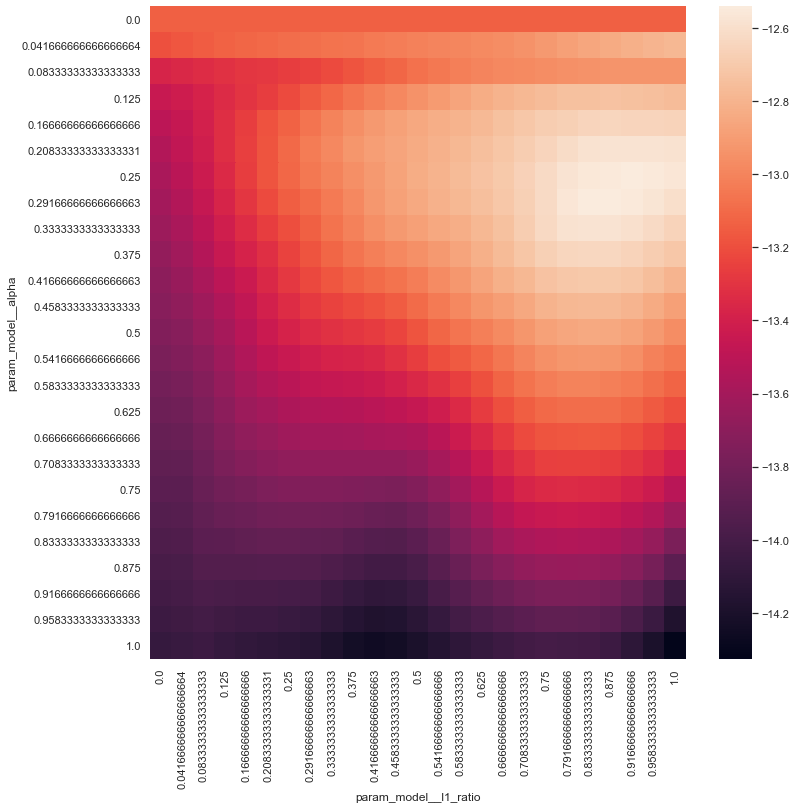

In [17]:
pvt = pd.pivot_table(pd.DataFrame(elastic_net_cv.cv_results_),
    values='mean_test_score', index='param_model__alpha', columns='param_model__l1_ratio')

plt.figure(figsize = (12,12))
ax = sns.heatmap(pvt)

The set performing best on average on the validatons set are shown below:

In [19]:
best_idx = elastic_net_cv.cv_results_['mean_test_score'].argmax()
alpha = elastic_net_cv.cv_results_['param_model__alpha'].data[best_idx]
l1_ratio = elastic_net_cv.cv_results_['param_model__l1_ratio'].data[best_idx]

print(f' alpha = {round(alpha, 3)}, l1-ratio: {round(l1_ratio,3)}')

alpha = 0.292, l1-ratio: 0.875


Using the above parameters and the full training set the final elastic model is tried on the testing set. We get a score of $R^2 \approx 0.55$.

In [20]:
y_pred = elastic_net_cv.predict(X_test)
print('R2: ', round(r2_score(y_test, y_pred),4))

R2:  0.5516


### Part 1.1 Coefficients Analysis

In [21]:
def plot_coef(model, df):
    # get the column transformer object from the pipe object:
    ColumnTransformer = model.get_params()['estimator__steps'][0][1]

    # exstract the numerical and categorical columns
    numerical_features = ColumnTransformer.transformers[0][2]
    categorical_features = ColumnTransformer.transformers[1][2]

    # One hot encode the the names if there is categorical columns
    if categorical_features:
        one_hot_names = [value.replace(" ", "_") for column in categorical_columns for value in df[column].value_counts().index]
    else:
        one_hot_names = []

    names = numerical_columns + one_hot_names

    coef_df = pd.DataFrame({
        'variable' : names,
        'coefficient' : model.best_estimator_.steps[-1][1].coef_,
        'feature' : np.concatenate((
            np.repeat('numeric_feature', len(numerical_columns)),
            np.repeat('categorical_feature', len(one_hot_names))
        ))
    })

    # Define figure, axes, and plot
    color_dict = {'numeric_feature': 'tab:blue', 'categorical_feature': 'tab:red'}

    # Manuelly adding legends...
    from matplotlib.lines import Line2D
    if len(coef_df['feature'].value_counts()) == 2:
        custom_lines = [Line2D([0], [0], color='tab:blue', lw=6),
                        Line2D([0], [0], color='tab:red', lw=6)]
    else:
        custom_lines = [Line2D([0], [0], color='tab:blue', lw=6)]


    fig, ax = plt.subplots(figsize=(20, 10))
    coef_df.plot(
        x = 'variable', y = 'coefficient', kind = 'bar',
        ax = ax, color = [color_dict[x] for x in coef_df.feature],
        legend = False
    )


    plt.title('Coefficients of Features',fontsize=20)
    ax.set_ylabel('Coefficients',fontsize=12)
    ax.set_xlabel(None)
    ax.legend(custom_lines, ['Numerical Feature', 'Categorical Feature'])
    plt.show()

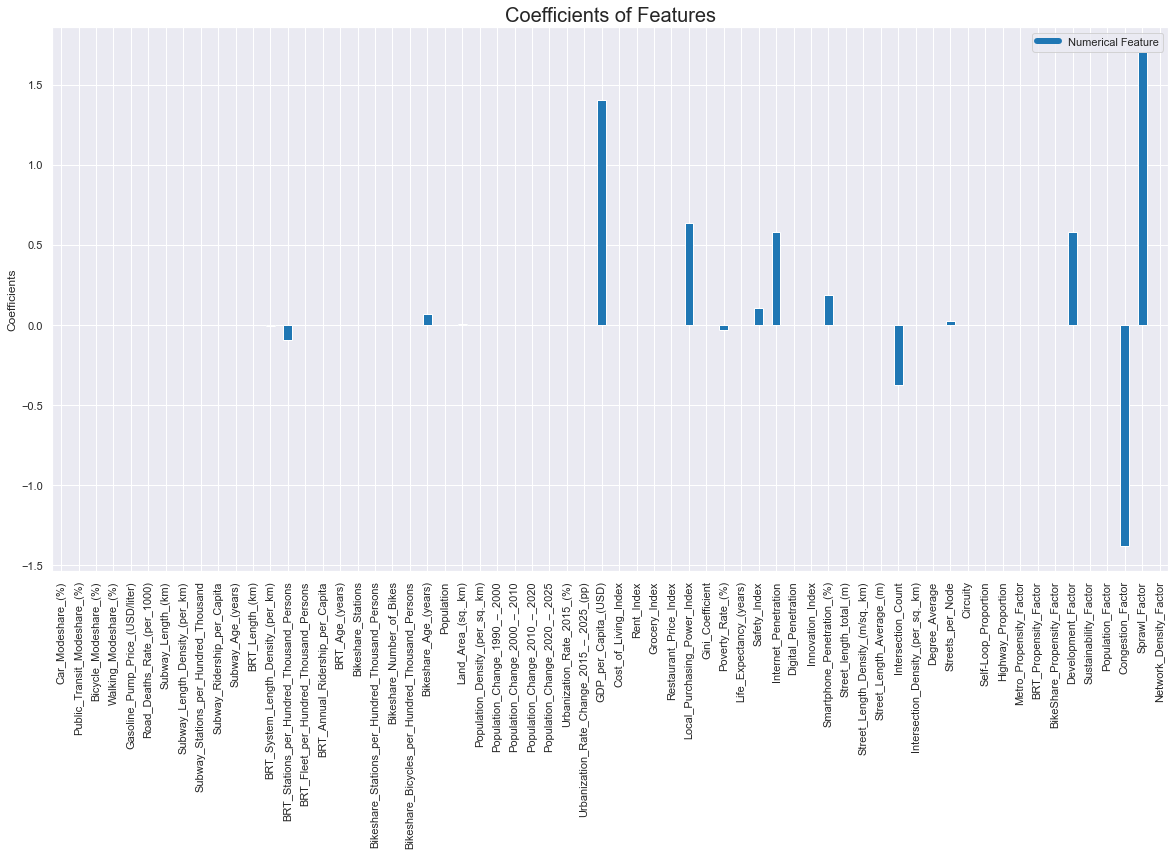

In [22]:
plot_coef(elastic_net_cv, X_train)


## Part 2: Prediction Challenge 2

In [23]:
X_test = X[(X['Continent'] == 'North America') | (X['Continent'] == 'South America')] 
y_test = y[(X['Continent'] == 'North America') | (X['Continent'] == 'South America')]

X_train = X[(X['Continent'] != 'North America') & (X['Continent'] != 'South America')] 
y_train = y[(X['Continent'] != 'North America') & (X['Continent'] != 'South America')]

In [24]:
colum_names = X_train.columns

no_info_column = [
    'City', 'cityID', 'clusterID', 'Country', 'Latitude', 'Longitude', 'Continent', 'Typology'
]

columns_with_nan = df.columns[df.isnull().any()].tolist()

remove_columns = no_info_column + columns_with_nan

categorical_columns = []

numerical_columns = [ column for column in colum_names if column not in remove_columns+categorical_columns ]


In [25]:
elastic_net_model = linear_model.ElasticNet(fit_intercept = False)

parameters = {
    'model__alpha': np.linspace(0, 1, 25),
    'model__l1_ratio': np.linspace(0, 1, 25)
}

elastic_net_pibe = getPipe(
    model = elastic_net_model,
    numerical_columns = numerical_columns,
    categorical_columns = categorical_columns
)


elastic_net_cv = cv(elastic_net_pibe, parameters, X_train, y_train, cf = 10)

Fitting 10 folds for each of 625 candidates, totalling 6250 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0621s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 276 

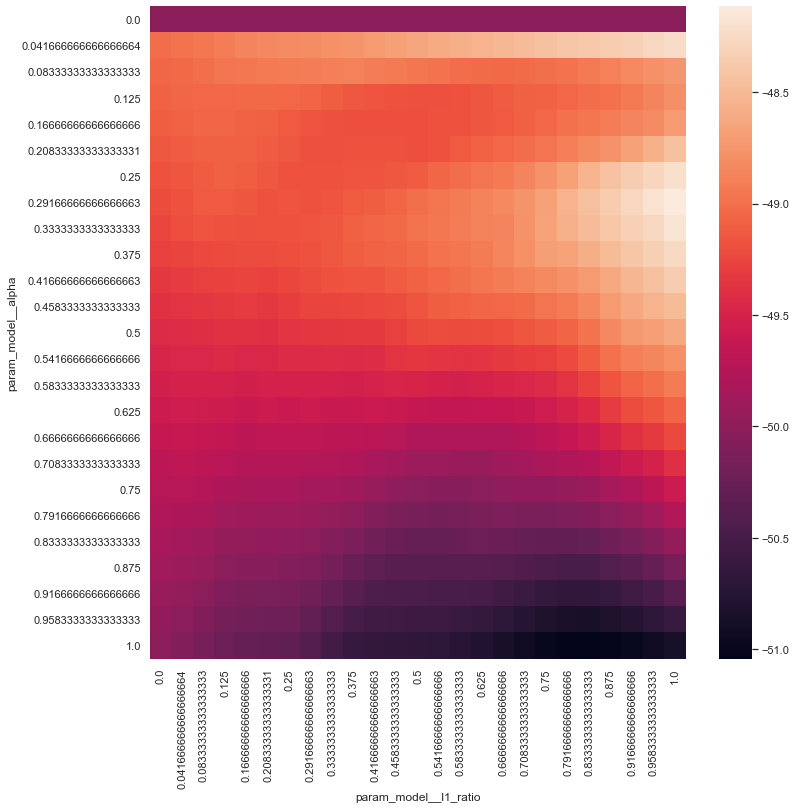

In [27]:
pvt = pd.pivot_table(pd.DataFrame(elastic_net_cv.cv_results_),
    values='mean_test_score', index='param_model__alpha', columns='param_model__l1_ratio')
plt.figure(figsize = (12,12))
ax = sns.heatmap(pvt)

In [26]:
best_idx = elastic_net_cv.cv_results_['mean_test_score'].argmax()
alpha = elastic_net_cv.cv_results_['param_model__alpha'].data[best_idx]
l1_ratio = elastic_net_cv.cv_results_['param_model__l1_ratio'].data[best_idx]

print(f' alpha = {round(alpha, 3)}, l1-ratio: {round(l1_ratio,3)}')

alpha = 0.292, l1-ratio: 1.0


In [28]:
y_pred = elastic_net_cv.predict(X_test)
print('R2: ', r2_score(y_test, y_pred))

R2:  0.38139957290256854


### Part 1.2 Coefficients Analysis

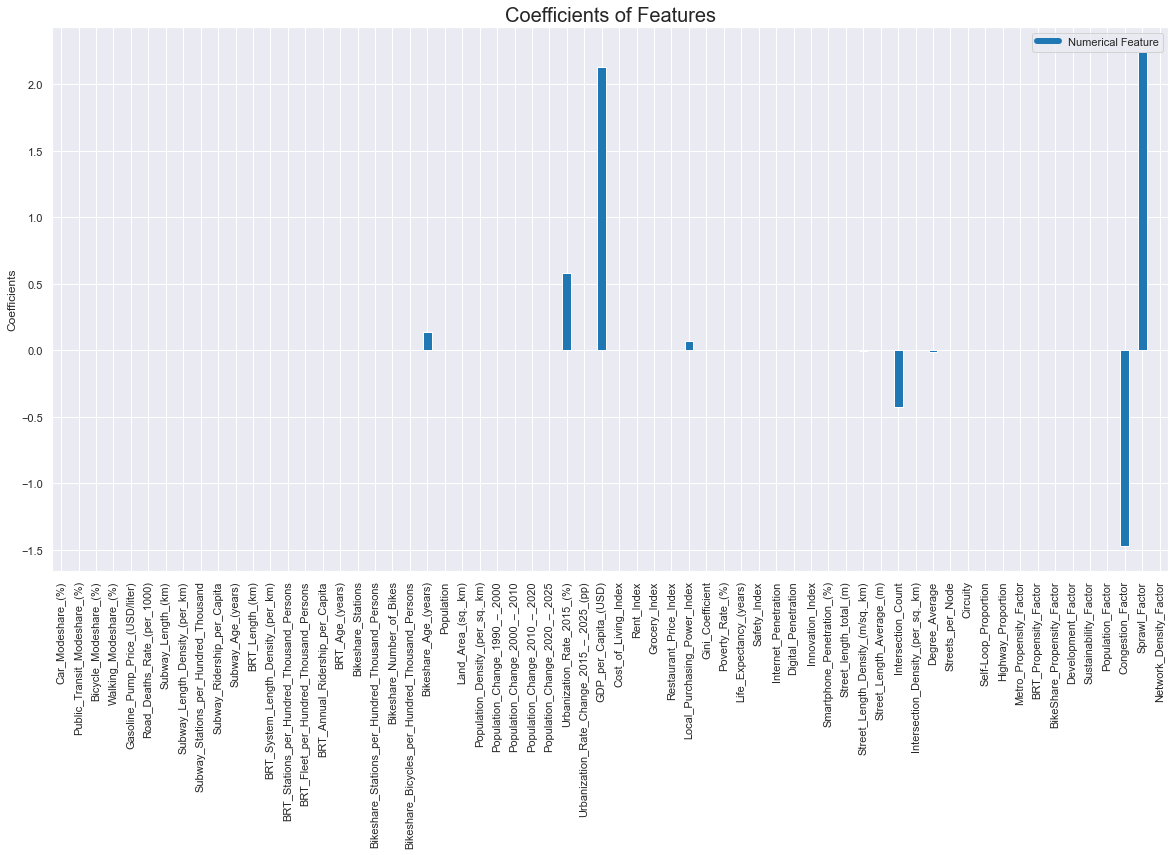

In [29]:
plot_coef(elastic_net_cv, X_train)

## Part 3: Trying out other regression models

In [58]:
X, y = split_target_and_predictors(
    data = df,
    target = 'CO2_Emissions_per_Capita_(metric_tonnes)',
    drop_cols = ['Pollution_Index_']
)

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.25, shuffle = False)


colum_names = X_train.columns
no_info_column = ['City', 'cityID', 'clusterID', 'Country', 'Latitude', 'Longitude', 'Typology']

columsn_with_nan = ['Bicycle_Modeshare_(%)', 'Congestion_(%)', 'Congestion_AM_Peak_(%)',
       'Congestion_PM_Peak_(%)', 'Traffic_Index', 'Travel_Time_Index',
       'Inefficiency_Index', 'Unemployment_Rate_(%)', 'Cost_of_Living_Index',
       'Rent_Index', 'Grocery_Index', 'Restaurant_Price_Index',
       'Local_Purchasing_Power_Index', 'Poverty_Rate_(%)', 'Safety_Index',
       'Pollution_Index_']

remove_columns = no_info_column + columsn_with_nan

categorical_columns = ['Continent']

numerical_columns = [ column for column in colum_names if column not in remove_columns+categorical_columns ]


In [59]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

import pickle

In [132]:
models = {
    'GBR': {
        'model' : GradientBoostingRegressor(),
        'parameters' : {
            'model__n_estimators':[100, 200, 300, 400, 500], 
            'model__learning_rate': [0.1, 0.05, 0.02],
            'model__max_depth': [3], 
            'model__min_samples_leaf':[3], 
        }
    },
    'RFR' : {
        'model' : RandomForestRegressor(),
        'parameters' : {
            'model__max_depth': [10, 20, None],
            'model__min_samples_leaf': [2],
            'model__min_samples_split': [2, 5, 10],
            'model__n_estimators': [100, 150, 200, 250]
        }
    },
    'SGDR' : {
        'model' : SGDRegressor(),
        'parameters' : {
            'model__penalty': ['elasticnet'],
            'model__alpha': np.logspace(-5, 1, 20),
            'model__l1_ratio': np.linspace(0, 1, 10)
        }
    },
    'KNNR' : {
        'model' : KNeighborsRegressor(),
        'parameters' : {
            'model__n_neighbors': np.linspace(5, 30, 6, dtype=np.int),
            'model__weights': ['uniform', 'distance'],
        }
    },
    'SVR' : {
        'model' : SVR(),
        'parameters' : {
            'model__kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),
            'model__C' : [1,5,10],
            'model__degree' : [3,8],
            'model__gamma' : ('auto','scale')
        },
    } 

}
for key in models:
    print('Fitting ', key)
    pipe = getPipe(
        model = models[key]['model'],
        numerical_columns = numerical_columns,
        categorical_columns = categorical_columns
    )
    pipe_cv = cv(pipe, models[key]['parameters'], X_train, y_train, cf = 10)
    
    y_pred = pipe_cv.predict(X_test)
    r2 =  r2_score(y_test, y_pred)

    models[key]['model_object'] = pipe_cv
    models[key]['r2'] = r2
    

Fitting  GBR
Fitting 10 folds for each of 15 candidates, totalling 150 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   50.5s finished
Fitting  RFR
Fitting 10 folds for

In [133]:
pickle.dump(models, open('models.pickle', 'wb'))

In [134]:
# read models
saved_model = pickle.load(open('models.pickle','rb'))

In [135]:
for model in saved_model:
    print(model, ' r2: ', saved_model[model]['r2'])

GBR  r2:  0.6183971871840381
RFR  r2:  0.5858701050150841
SGDR  r2:  0.5882405408322343
KNNR  r2:  0.46059912138069103
SVR  r2:  0.620839945264722


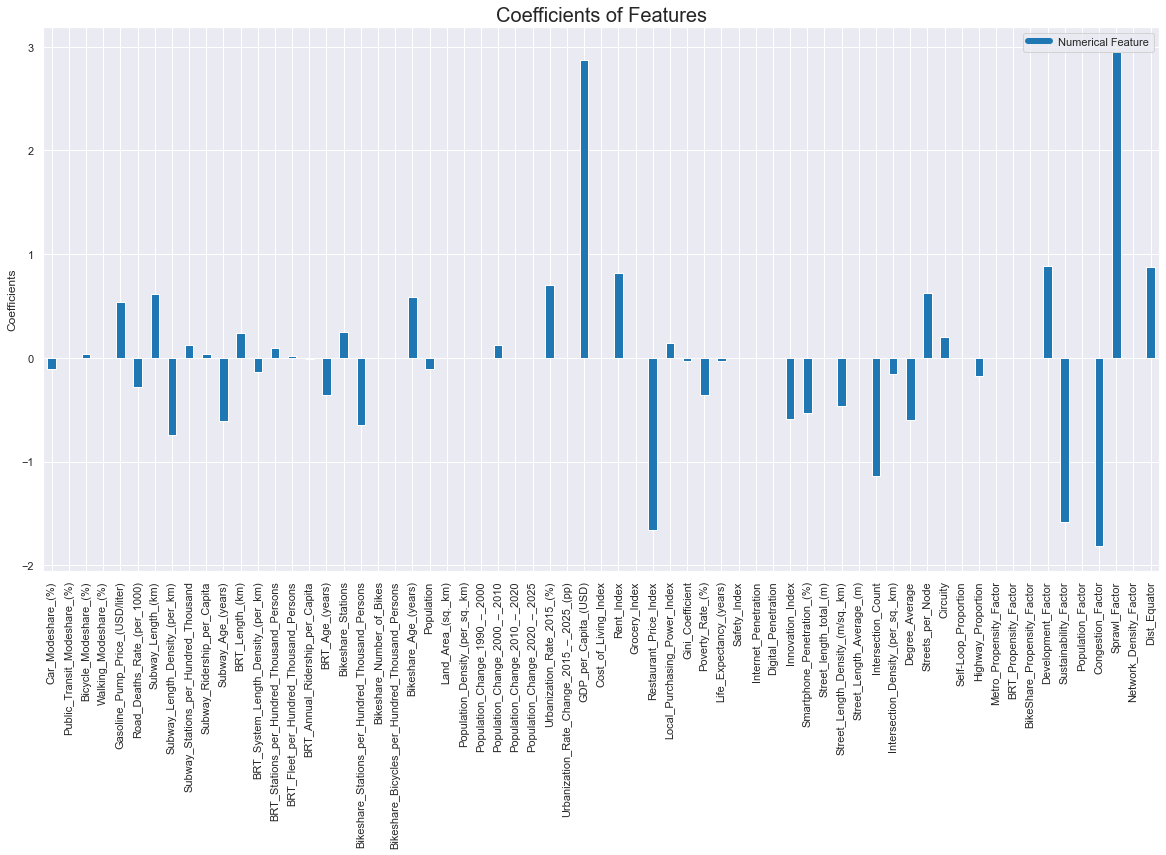

In [186]:
plot_coef(elastic_net_cv, X_train)